In [1]:
import pandas as pd
from pandas import Series, DataFrame
import folium
from folium import plugins
import json
import geopandas as gpd
import numpy as np
from geoband.API import *
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [3]:
data_merge = gpd.read_file('data_english.geojson')

In [4]:
data_merge.columns

Index(['gid', 'acci_cnt', 'death', 'serious', 'slightly', 'count_injured',
       'sign_w', 'sign_c', 'crosswalk', 'sign_speed', 'nostop',
       'traffic_signs', 'cctv', 'old', 'young', 'ppop', 'node', 'safezone',
       'cars_cnt', 'avrg_temp', 'low_temp', 'high_temp', 'max_ws', 'avrg_ws',
       'avrg_humid', 'surface_temp', 'rain_count', 'snow_count', 'humid_count',
       'geometry'],
      dtype='object')

In [5]:
# OLS 검정
result = sm.ols(data=data_merge, formula = 'acci_cnt ~ death + serious + sign_c + crosswalk + sign_speed + nostop + traffic_signs + cctv + young + ppop + node + avrg_temp + high_temp + max_ws + avrg_ws + avrg_humid + rain_count + snow_count + humid_count').fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acci_cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     1852.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:49:20   Log-Likelihood:                -13152.
No. Observations:                6067   AIC:                         2.634e+04
Df Residuals:                    6047   BIC:                         2.648e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.9821      0.388     10.262      0.000       3.221       4.743
death             0.3881      0.127      3.052      0.002       0.139       0.637
serious           0.7731      0.021     36.745      0.000       0.732       0.814
sign_c            0.0626      0.013      4.642      0.000       0.036       0.089
crosswalk         0.0547      0.021      2.586      0.010       0.013       0.096
sign_speed        0.1076      0.020      5.315      0.000       0.068       0.147
nostop            1.1195      0.291      3.847      0.000       0.549       1.690
traffic_signs     0.0132      0.009      1.429      0.153      -0.005       0.031
cctv              1.1917      0.149      7.989      0.000       0.899       1.484
young            -0.0053      0.002     -2.361      0.018      -0.010      -0.001
ppop              0.0009      0.000      2.086      0.037    5.51e-05       0.002
node              0.2439      0.058      4.224      0.000       0.131       0.357
avrg_temp        -0.1501      0.027     -5.635      0.000      -0.202      -0.098
high_temp         0.1806      0.026      6.970      0.000       0.130       0.231
max_ws           -0.3722      0.046     -8.141      0.000      -0.462      -0.283
avrg_ws           0.1751      0.094      1.858      0.063      -0.010       0.360
avrg_humid       -0.0577      0.004    -15.550      0.000      -0.065      -0.050
rain_count        1.9382      0.025     77.987      0.000       1.889       1.987
snow_count        0.5365      0.080      6.713      0.000       0.380       0.693
humid_count       0.8401      0.067     12.626      0.000       0.710       0.971
==============================================================================
Omnibus:                     2814.245   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91922.251
Skew:                           1.588   Prob(JB):                         0.00
Kurtosis:                      21.803   Cond. No.                     2.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

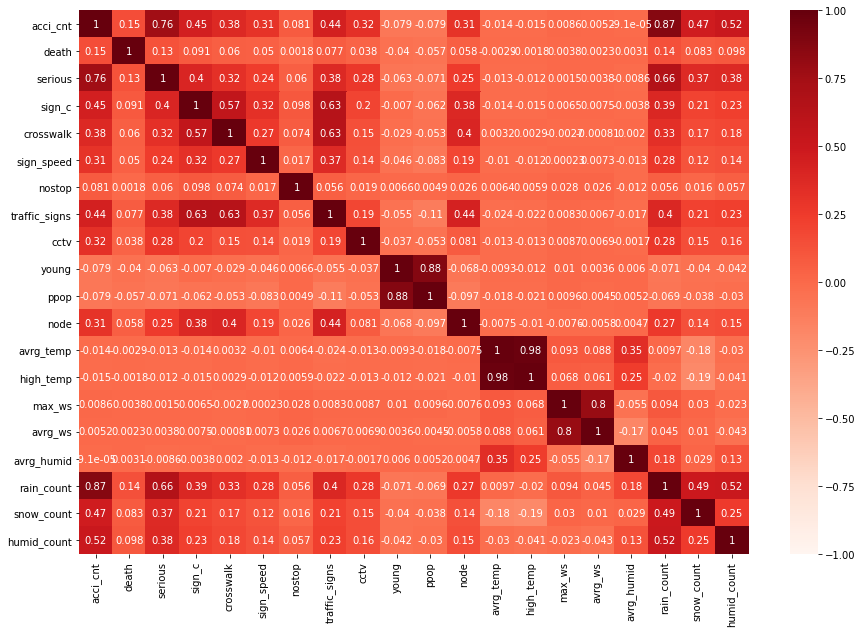

In [6]:
# 상관관계
import seaborn as sb
df_corr=data_merge[['acci_cnt', 'death', 'serious',
       'sign_c', 'crosswalk', 'sign_speed', 'nostop',
       'traffic_signs', 'cctv', 'young', 'ppop', 'node', 'avrg_temp', 'high_temp', 'max_ws', 'avrg_ws',
       'avrg_humid', 'rain_count', 'snow_count', 'humid_count']]
plt.rcParams['figure.figsize']=(15,10)

sb.heatmap(df_corr.corr(),
          annot=True,
          cmap='Reds',
          vmin = -1, vmax = 1
          )

In [7]:
# 다중공선성(Multicollinearity) 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_corr.values, i) for i in range(df_corr.shape[1])]
vif["features"] = df_corr.columns
vif.to_csv('vif_1.csv')

In [8]:
vif

VIF Factor       features
0    10.041361       acci_cnt
1     1.068242          death
2     3.167644        serious
3     2.597175         sign_c
4     3.225490      crosswalk
5     1.601929     sign_speed
6     1.022241         nostop
7     4.137750  traffic_signs
8     1.142809           cctv
9     5.248418          young
10    6.276678           ppop
11    1.685583           node
12   93.312062      avrg_temp
13  155.768949      high_temp
14   45.826464         max_ws
15   26.650712        avrg_ws
16   20.068524     avrg_humid
17    7.294062     rain_count
18    1.535012     snow_count
19    1.611019    humid_count

In [9]:
# 다중공선성이 높은 high_temp, max_ws, avrg_humid 제거
df_corr=df_corr.drop(['high_temp','max_ws','avrg_humid'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_corr.values, i) for i in range(df_corr.shape[1])]
vif["features"] = df_corr.columns
vif.to_csv('vif_2.csv')
vif

VIF Factor       features
0     9.005502       acci_cnt
1     1.066987          death
2     3.166865        serious
3     2.588346         sign_c
4     3.205443      crosswalk
5     1.595869     sign_speed
6     1.021144         nostop
7     4.068170  traffic_signs
8     1.141529           cctv
9     5.197131          young
10    6.050886           ppop
11    1.683110           node
12    3.590234      avrg_temp
13    4.300086        avrg_ws
14    6.132420     rain_count
15    1.519158     snow_count
16    1.591042    humid_count